In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

# make sure you have these to make dendrograms!-------
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt
#-----------------------------------------------------

%matplotlib inline
from IPython.display import display  # Import display for Jupyter

# Review

Hierarchical clustering (as the name suggests) assumes that the clusters in the data have a hierarchical relationship. For example, in a McDonald's food dataset we could have clusters like: Dessert, Drinks, Sandwhiches, Other. Within Sandwhiches we could have chicken sandwhiches, Burgers, Vegan Sandwhiches...within Burgers we could have smaller, lower calorie options, and bigger, more substantial burgers...etc.

Blood cells is another great example of a hierarchical relationship: ![blood hierarchy](https://community.jmp.com/t5/image/serverpage/image-id/16820i93FA5BD273E0A842/image-dimensions/340x314?v=1.0)

Hierarchical *Agglomeretive* Clustering (which we perform here), goes bottom up: every datapoint starts as it's own singleton cluster, and at each step, we merge the two closest clusters together until all data points are in one big cluster. In order to decide which clusters are closest, we need to choose two things:

## Distance Metrics and Linkage Critera

* **distance metric**: this is a measure that helps us define how close together two *data points* are. Euclidean distance is a common distance metric that you may be familiar with, but there is also cosine distance, manhattan distance, hamming distance, and even custom distance functions (like [levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance) between two strings!)
* **linkage criteria**: this is a measure of how close two *clusters* are. Because (most) clusters have more than one point, we need to define what it means for two clusters to be close.
    * **Single Linkage**: the distance between two clusters (A and B) as the minimum distance between any point in A and any point in B ![single linkage](https://community.jmp.com/t5/image/serverpage/image-id/16823iF32133201794C0A4/image-dimensions/251x242?v=1.0)
    * **Average Linkage**: the distance between two clusters (A and B) as the average distance between points in A and points in B. ![average linkage](https://community.jmp.com/t5/image/serverpage/image-id/16824iDD065DCADD44D5EC/image-dimensions/275x307?v=1.0)
    * **Complete Linkage**: the distance between two clusters (A and B) as the maximum distance between any point in A and any point in B. ![complete linkage](https://community.jmp.com/t5/image/serverpage/image-id/16825i39A778742E501081/image-dimensions/277x245?v=1.0)
    * **Centroid Method**: the distance between two clusters (A and B) as the distance between their respective mean vectors (centroids). ![centroid method](https://community.jmp.com/t5/image/serverpage/image-id/16826iFC5E179AEFFF1252/image-dimensions/260x268?v=1.0)
    * **Ward's Method** (default): the distance between two clusters (A and B) as the Sum of Squared Errors when combining the two clusters together. ![ward's method](https://community.jmp.com/t5/image/serverpage/image-id/16827iA35DD99890489DB2/image-dimensions/253x164?v=1.0)
    * and MORE! You could technically define this anyway you wanted.


## Dendrograms

### Diffuse Overlapping Clusters
<img src="https://drive.google.com/uc?export=view&id=1OCGvoe2FtZdIm0NnXbuwDo49E9CDrkIc" width = 600px />

### Highly Separable Clusters
<img src="https://drive.google.com/uc?export=view&id=1xpYaV-Pa1agH7H-OLzRvCcSWU-k78Uzf" width = 600px />

### Let's Try on Our Own

#### 1.
<img src="https://drive.google.com/uc?export=view&id=1ilZW8x11EjSAYub7jFM_kN4DxLMsgvOx" width = 500px />

#### 2.
<img src="https://drive.google.com/uc?export=view&id=1bz5MM_HZe30uLLesgCXZkEhfcgmVHG43" width = 500px />

#### 3.
<img src="https://drive.google.com/uc?export=view&id=1b3VHTE0WqmgtVa8ywtJX6sQkvjVadQ6D" width = 500px />


## `sklearn`

Like with all our other clustering algorithms, the `sklearn` code to fit an HAC model is largely the same as all the other clustering models.


In [ ]:
# read in data
tests_wide = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/testperform.csv")

tests_wide.head()

,zero,one,two,three,four,id
0,64.27,65.950884,69.865513,70.071844,71.557456,1
1,65.42,68.334638,71.774954,71.488519,72.414197,2
2,71.58,75.002741,77.169056,80.038548,80.307990,3
3,51.71,52.610899,53.005482,51.800135,53.829034,4
4,73.18,74.575287,76.507547,76.102415,75.441424,5


In [ ]:
# set up X/feats
features = ["zero", "one", "two", "three", "four"]
X = tests_wide[features]

# create empty model
z = make_column_transformer((StandardScaler(), features),
                            remainder = "passthrough")

hac = AgglomerativeClustering(metric = "euclidean",
                             linkage = "ward",
                             distance_threshold=0,
                             n_clusters = None) # come back and change the number of clusters

pipe = Pipeline([("z", z),
                 ("model", hac)])


# fit model and get labels
labels = pipe.fit_predict(X[features])

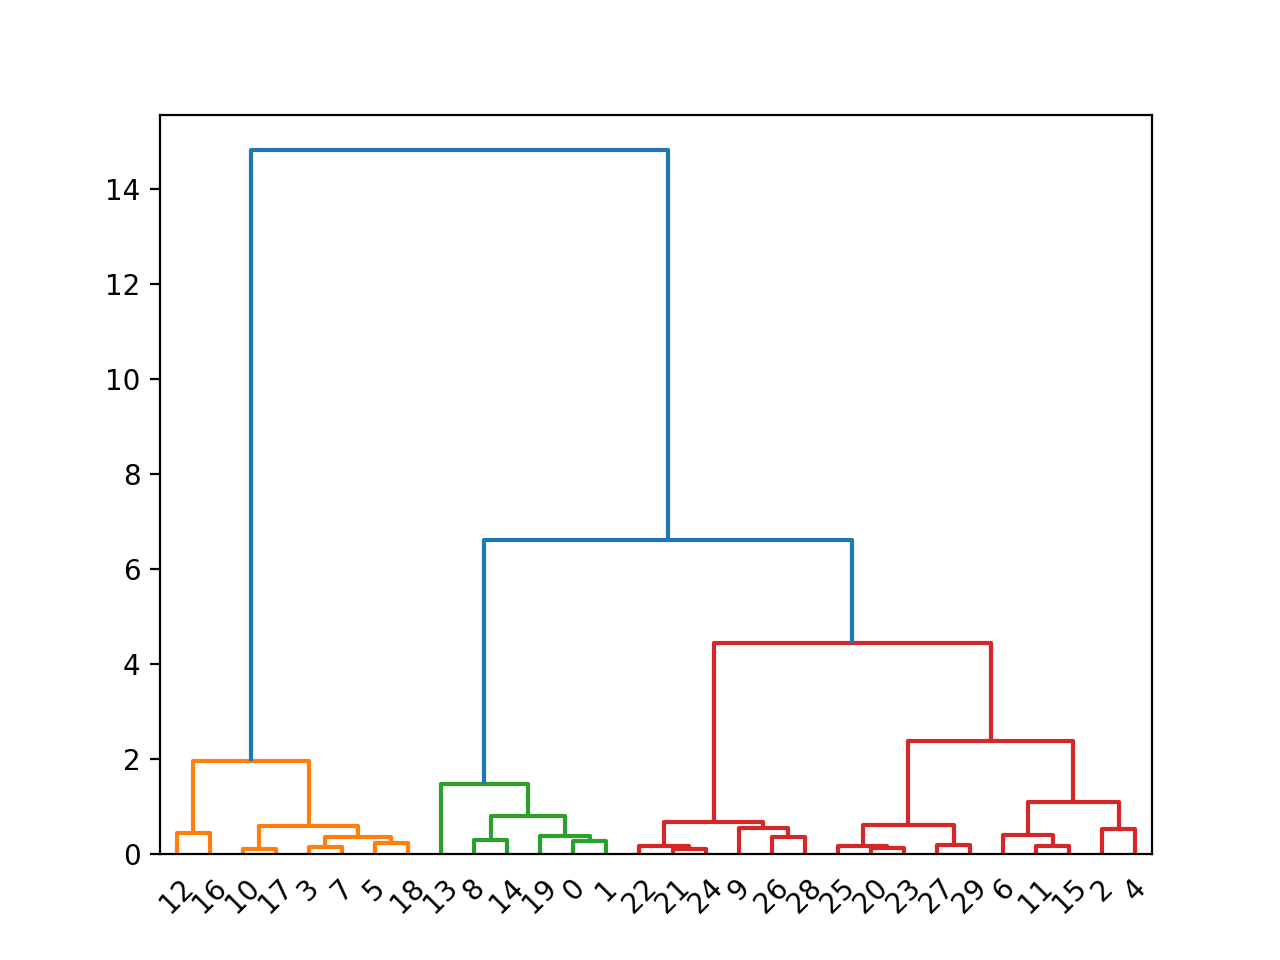

In [ ]:
# from sklearn: https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py
def plot_dendrogram(pipe, **kwargs):

    if "model" not in pipe.named_steps.keys():
        raise NameError("Your clustering pipeline step must be called 'model' for this function to work.")

    # create the counts of samples under each node
    counts = np.zeros(pipe.named_steps["model"].children_.shape[0])
    n_samples = len(pipe.named_steps["model"].labels_)
    for i, merge in enumerate(pipe.named_steps["model"].children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [pipe.named_steps["model"].children_, pipe.named_steps["model"].distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    sch.dendrogram(linkage_matrix, **kwargs)


plot_dendrogram(pipe, color_threshold = 5)

0.5275892679012398


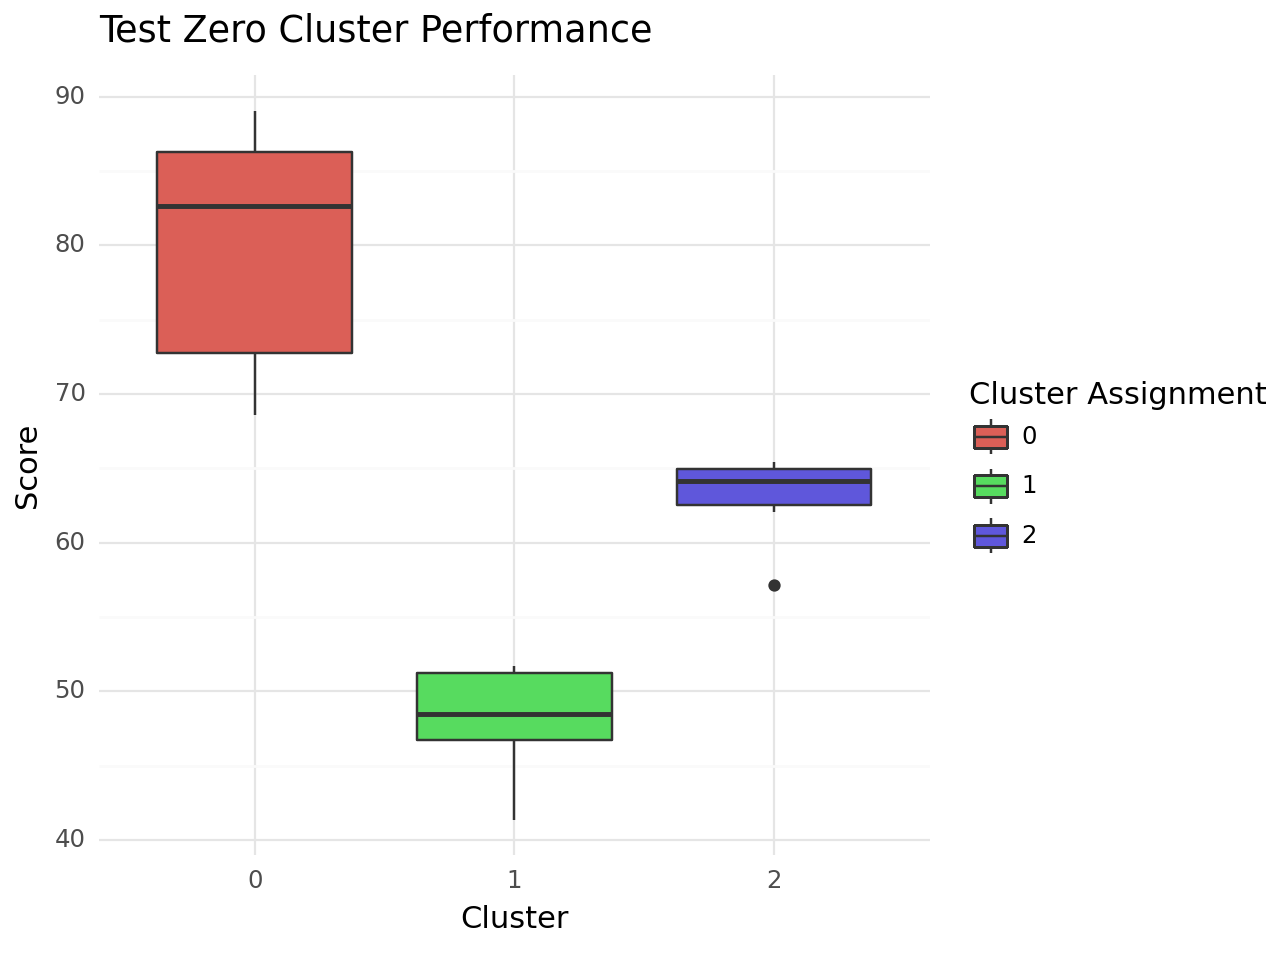

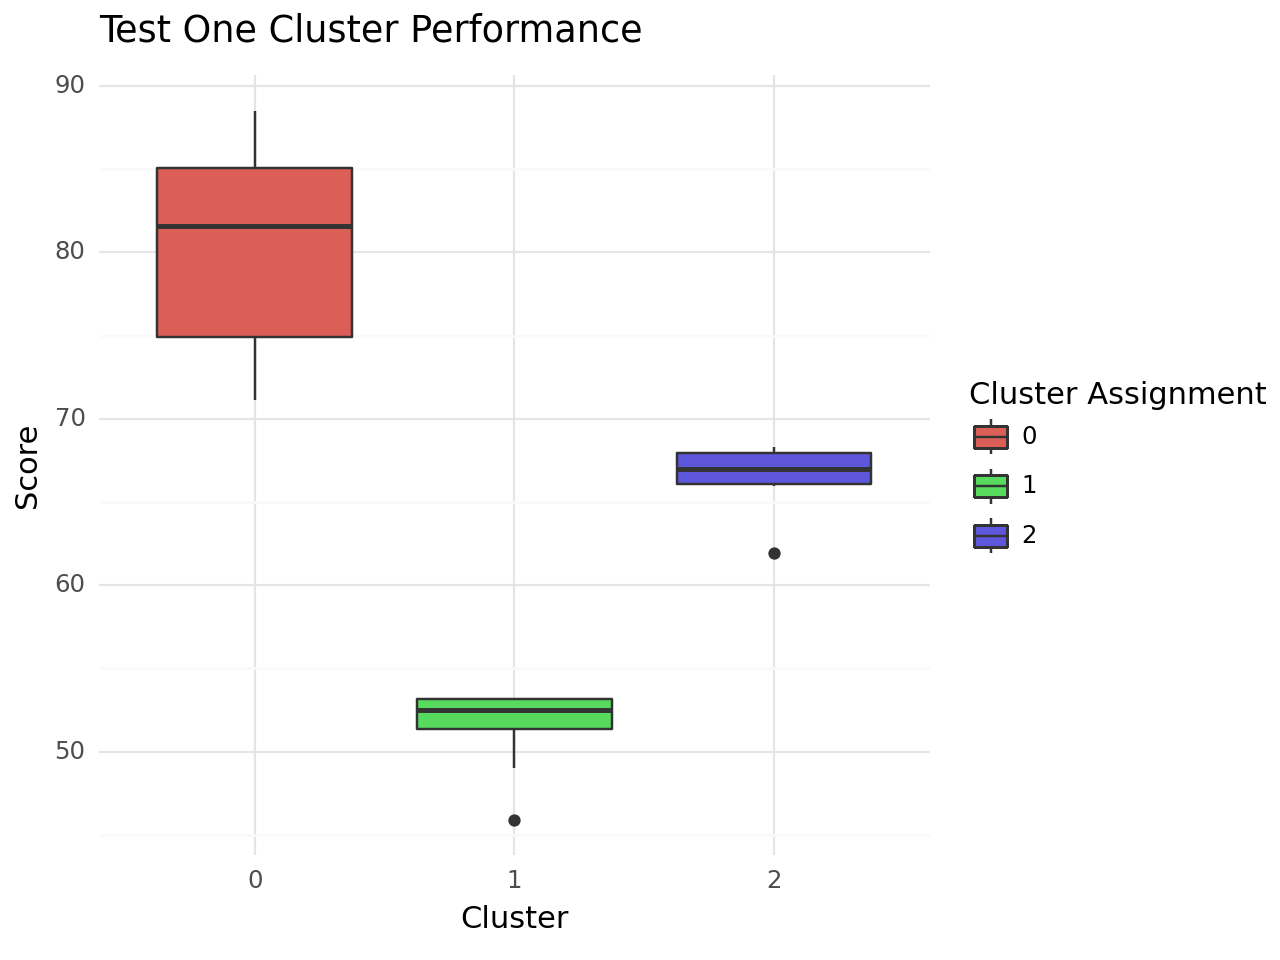

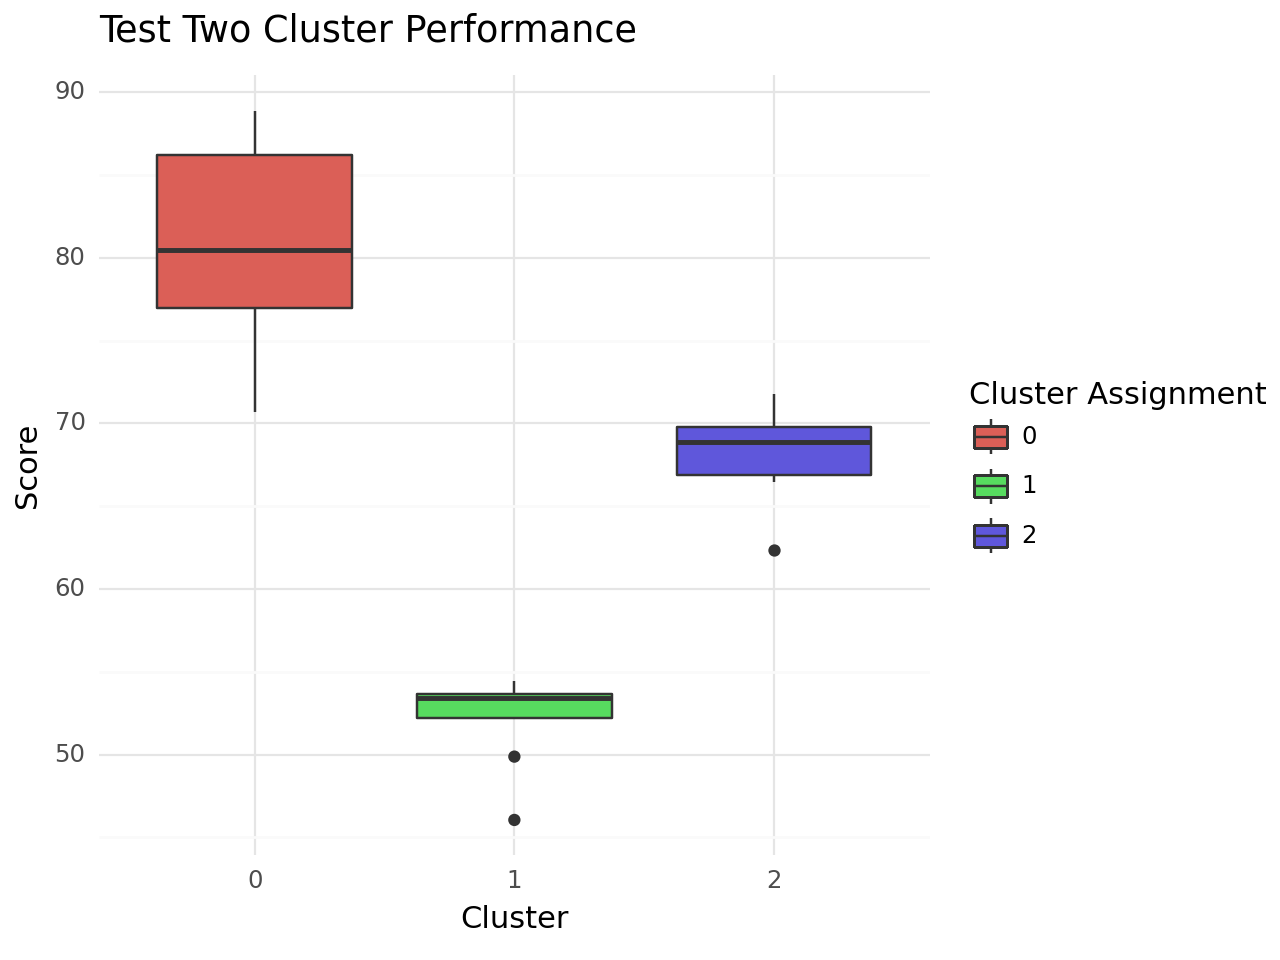

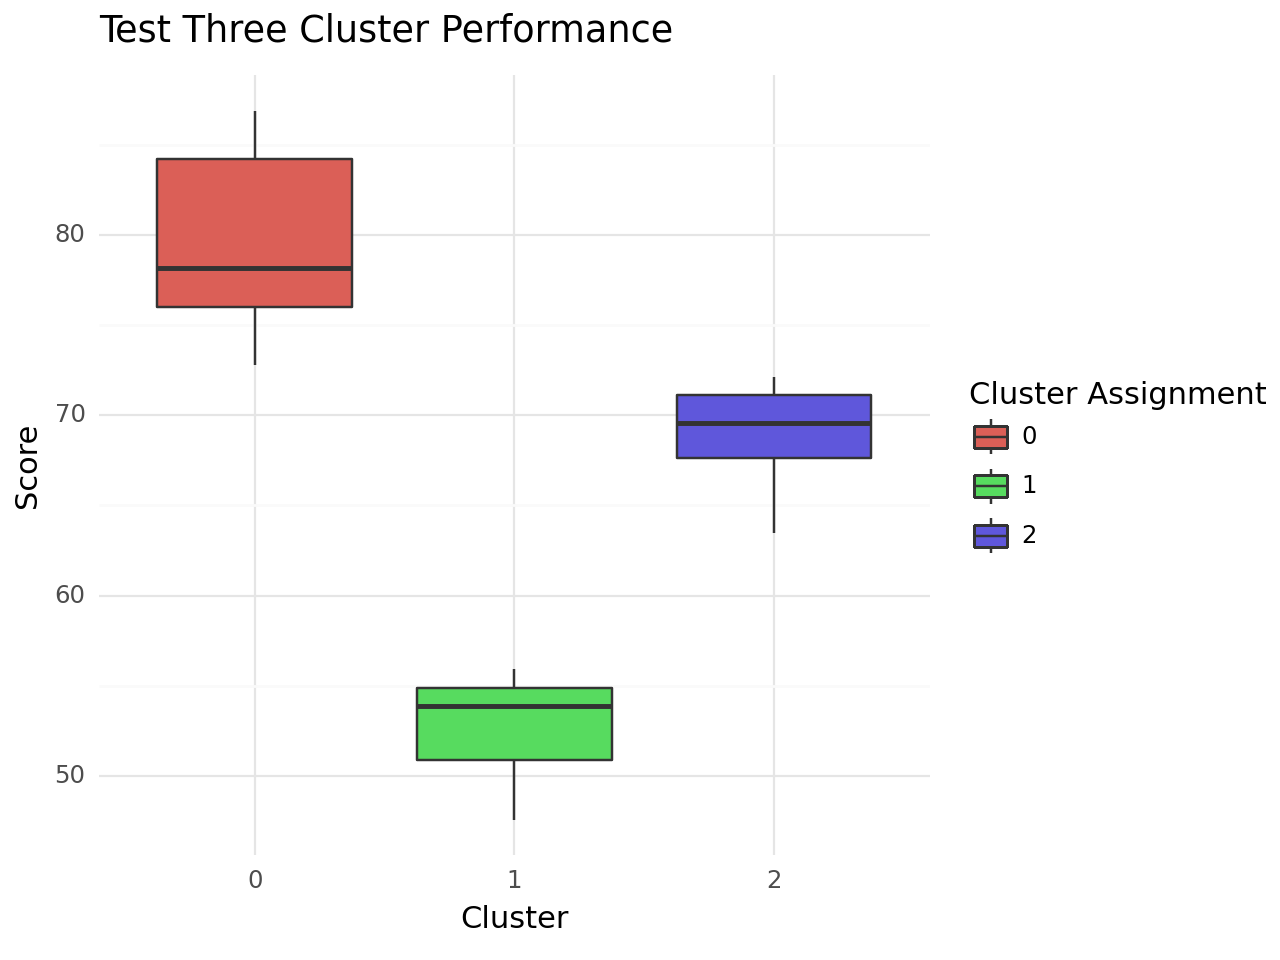

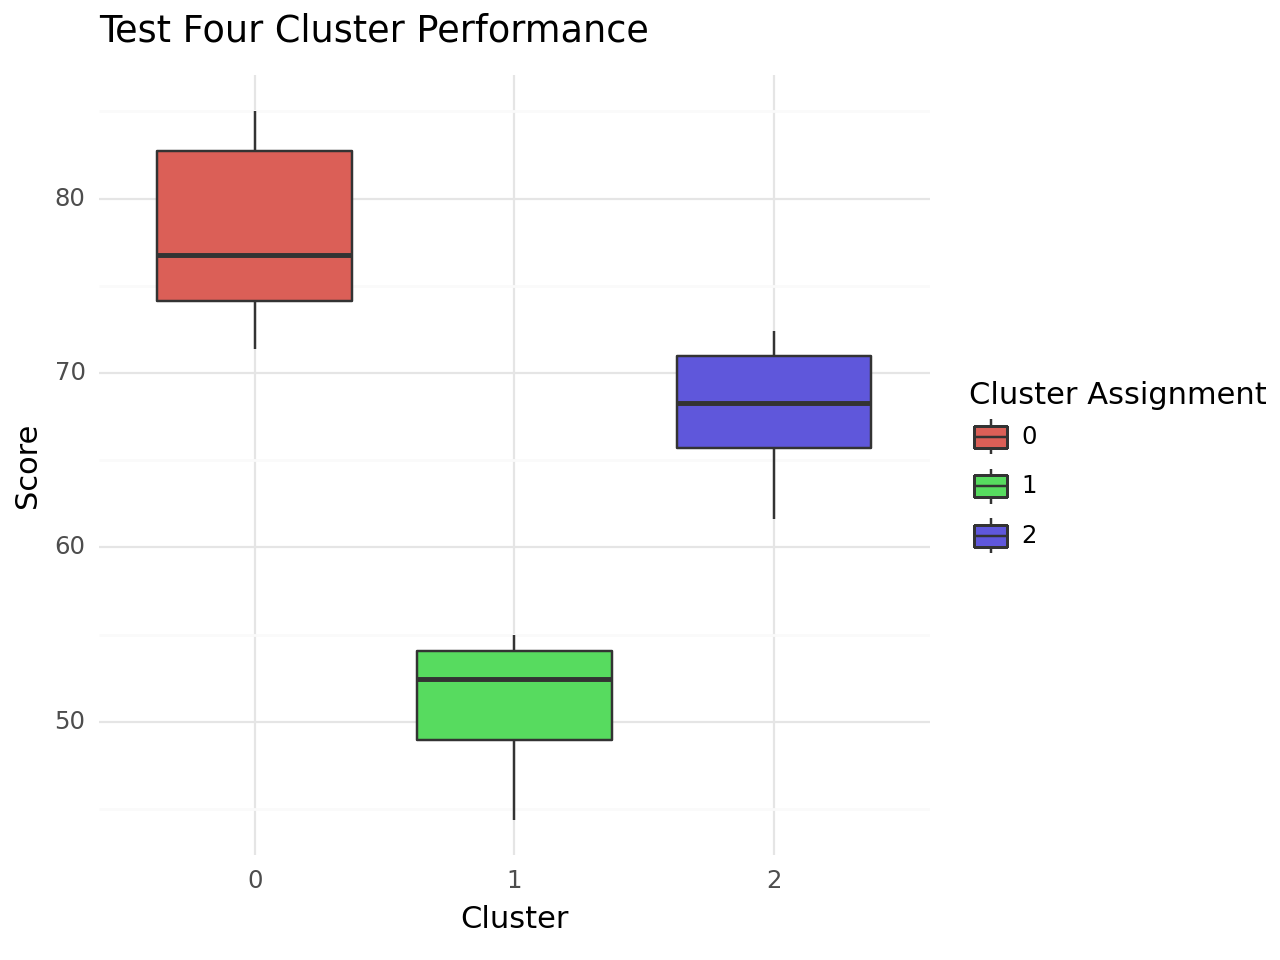

In [ ]:
# refit model with # of clusters you want
hac = AgglomerativeClustering(metric = "euclidean",
                             linkage = "ward",
                             n_clusters = 3) # come back and change the number of clusters

pipe = Pipeline([("z", z),
                 ("model", hac)])


# fit model and get labels
labels = pipe.fit_predict(X[features])

# sil scor
print(silhouette_score(X[features], labels))

# look at cluster performance
tests_wide["cluster_3"] = labels

for test in features:
    title = "Test " + test.capitalize() + " Cluster Performance"
    display(ggplot(tests_wide, aes(x = "factor(cluster_3)", y = test))
          + geom_boxplot(aes(fill = "factor(cluster_3)")) +
          theme_minimal() +
          scale_fill_discrete(name = "Cluster Assignment") +
          labs(x = "Cluster",
               y = "Score",
               title = title))

## Another Example

Let's look at some makeup purchasing data and cluster customers into groups.

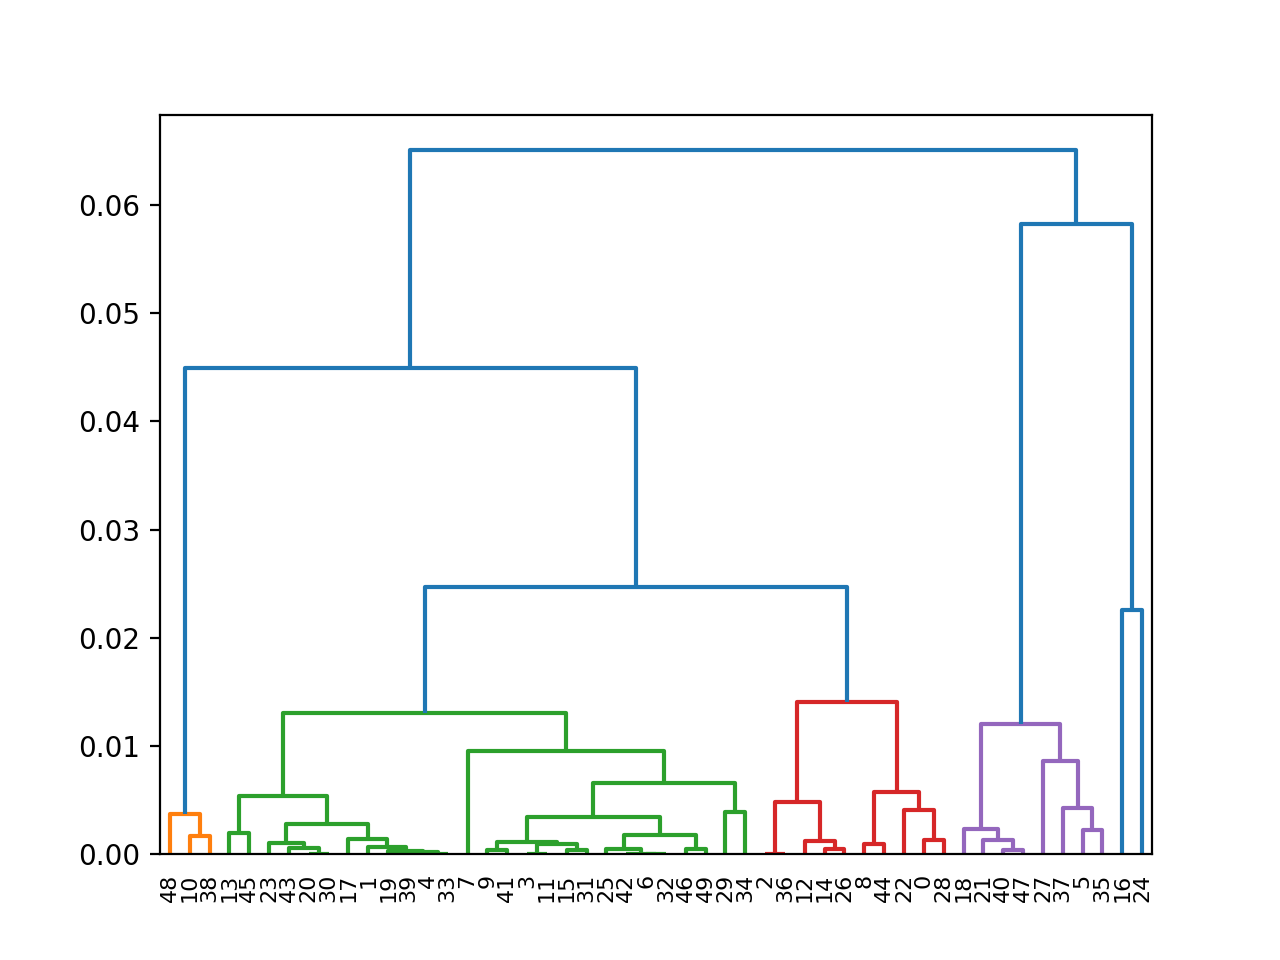

In [ ]:
# load in data
makeup = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/makeup.csv")
makeup.head()

# set up features
features = ["eyeshaddow", "lipstick", "foundation"]

X = makeup[features]

# create empty model
hac = AgglomerativeClustering(metric = "cosine",
                             linkage = "average",
                             distance_threshold= 0,
                             n_clusters = None) # come back and change the number of clusters

pipe2 = Pipeline([("model", hac)])


# fit model and get labels
labels = pipe2.fit_predict(X[features])

# assess
plot_dendrogram(pipe2, color_threshold= 0.015)

0.20332793465253482


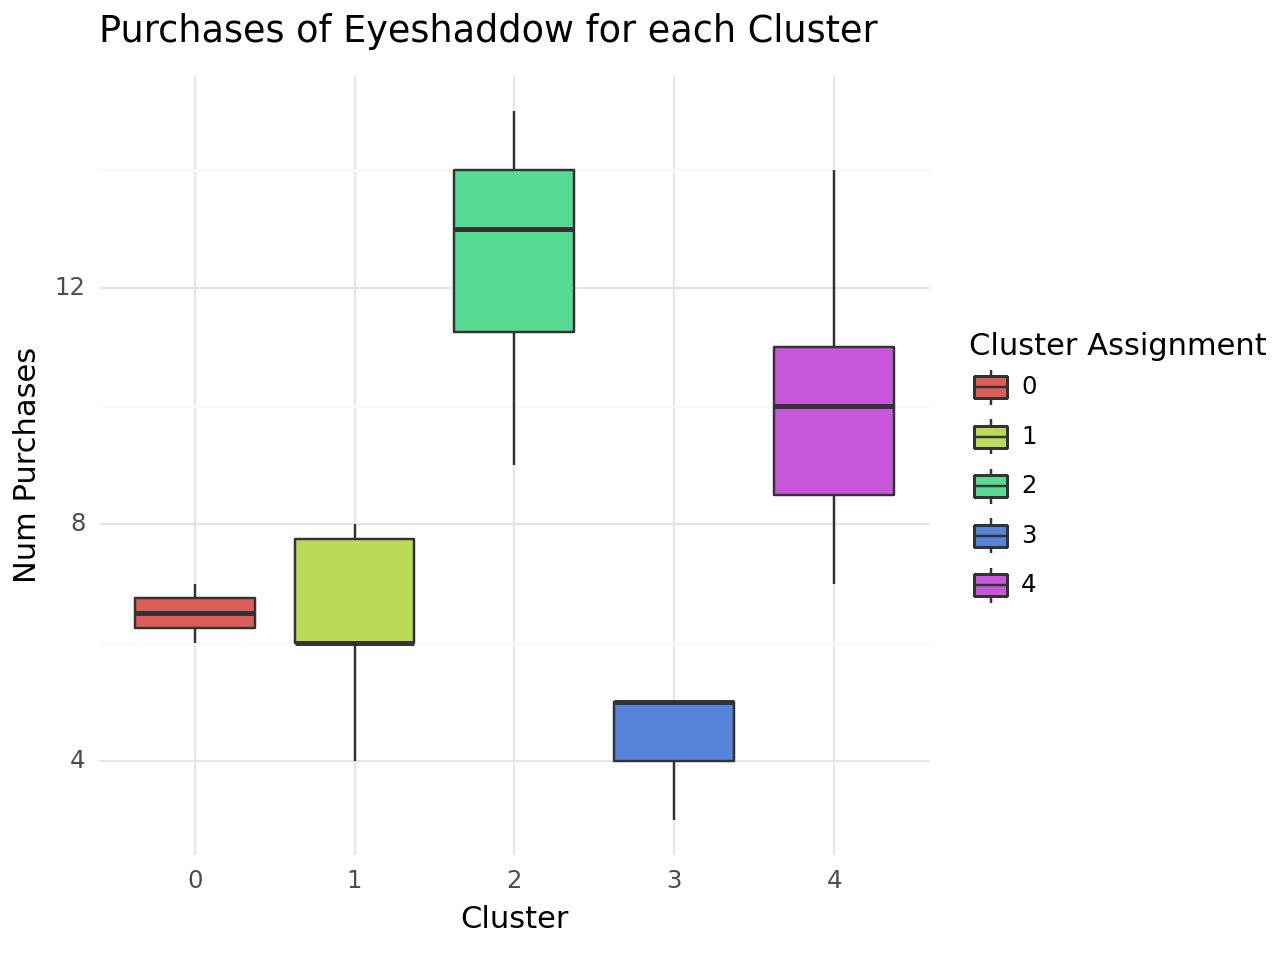

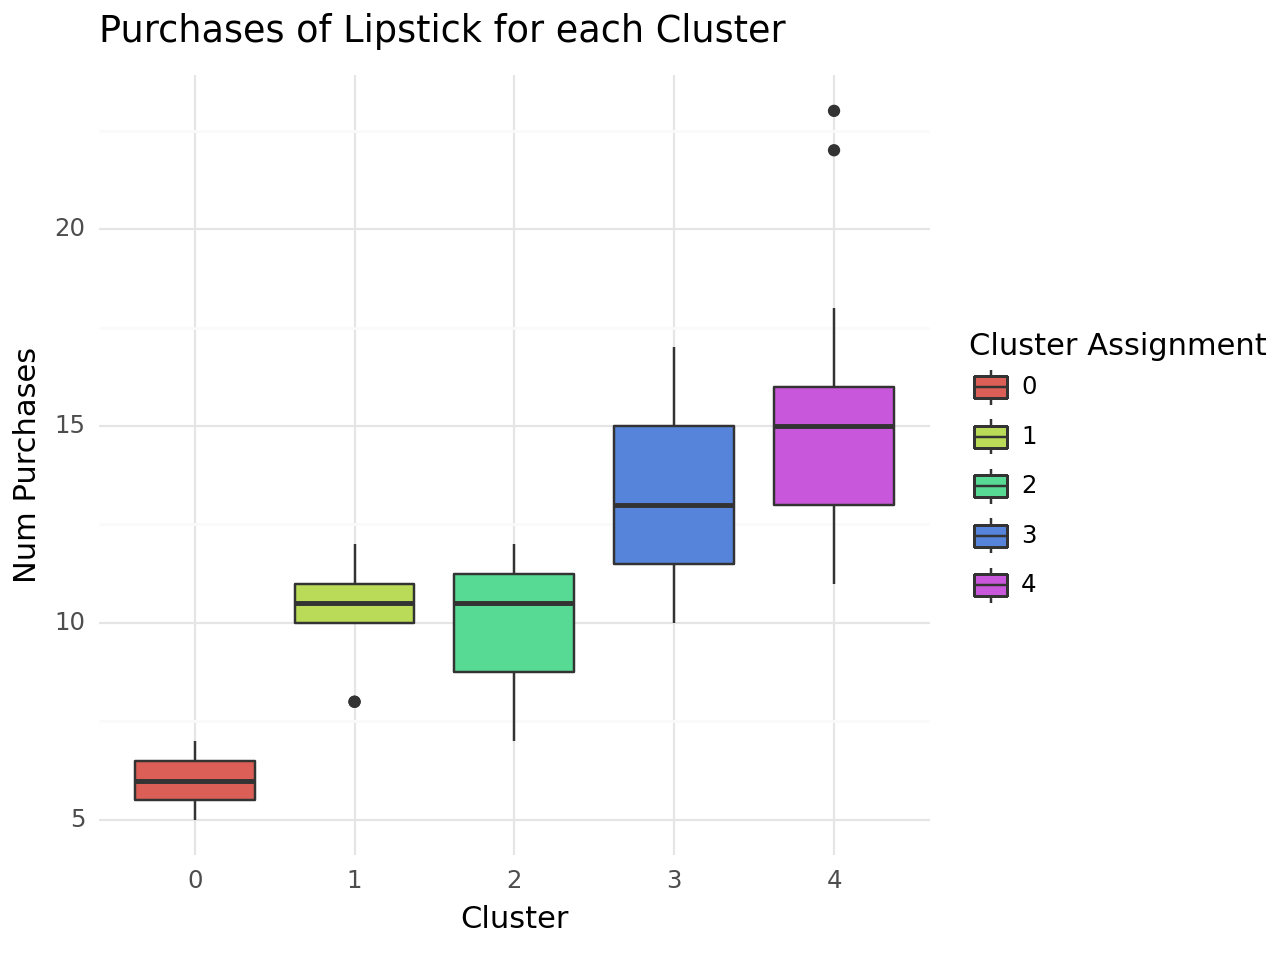

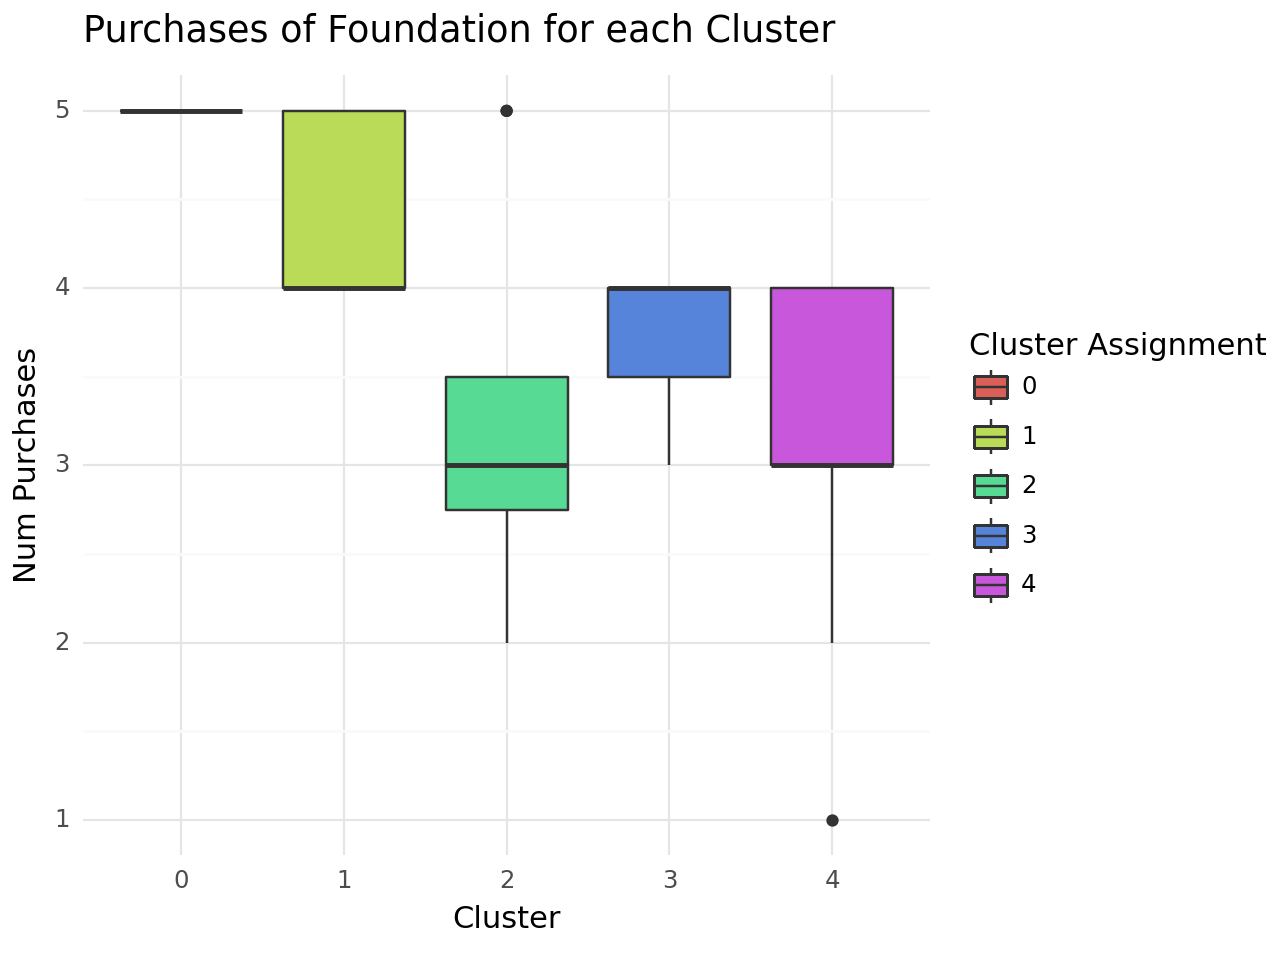

In [ ]:
# re-fit empty model with num clusters
hac = AgglomerativeClustering(metric = "cosine",
                             linkage = "average",
                             n_clusters = 5) # come back and change the number of clusters

pipe2 = Pipeline([("model", hac)])


# fit model and get labels
labels = pipe2.fit_predict(X[features])

# look at cluster performance
print(silhouette_score(X[features], labels))
makeup["cluster_5"] = labels

for product in features:
    title = "Purchases of " + product.capitalize() + " for each Cluster"
    display(ggplot(makeup, aes(x = "factor(cluster_5)", y = product))
          + geom_boxplot(aes(fill = "factor(cluster_5)")) +
          theme_minimal() +
          scale_fill_discrete(name = "Cluster Assignment") +
          labs(x = "Cluster",
               y = "Num Purchases",
               title = title))

## Yet Another Example

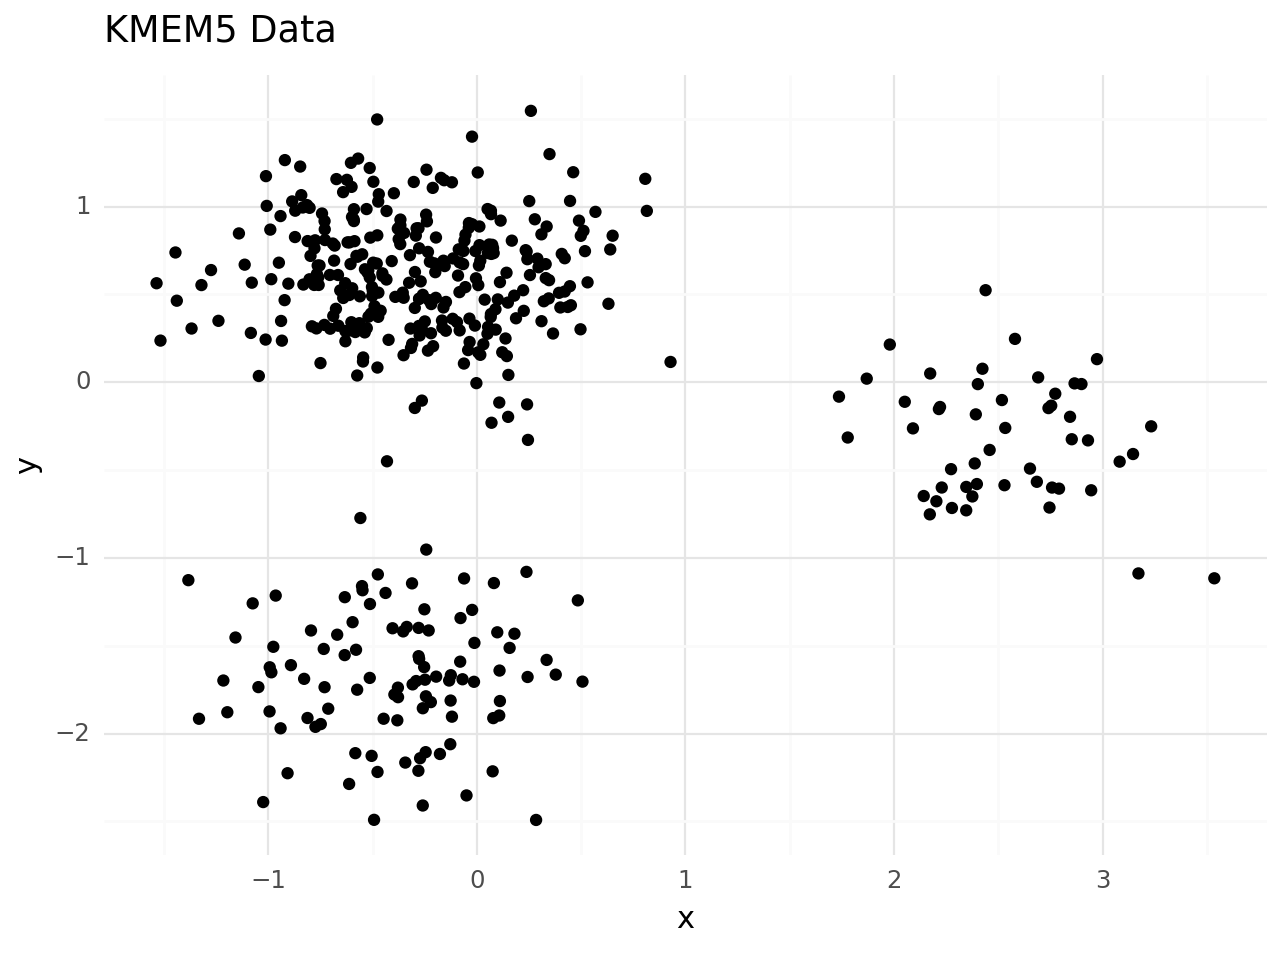

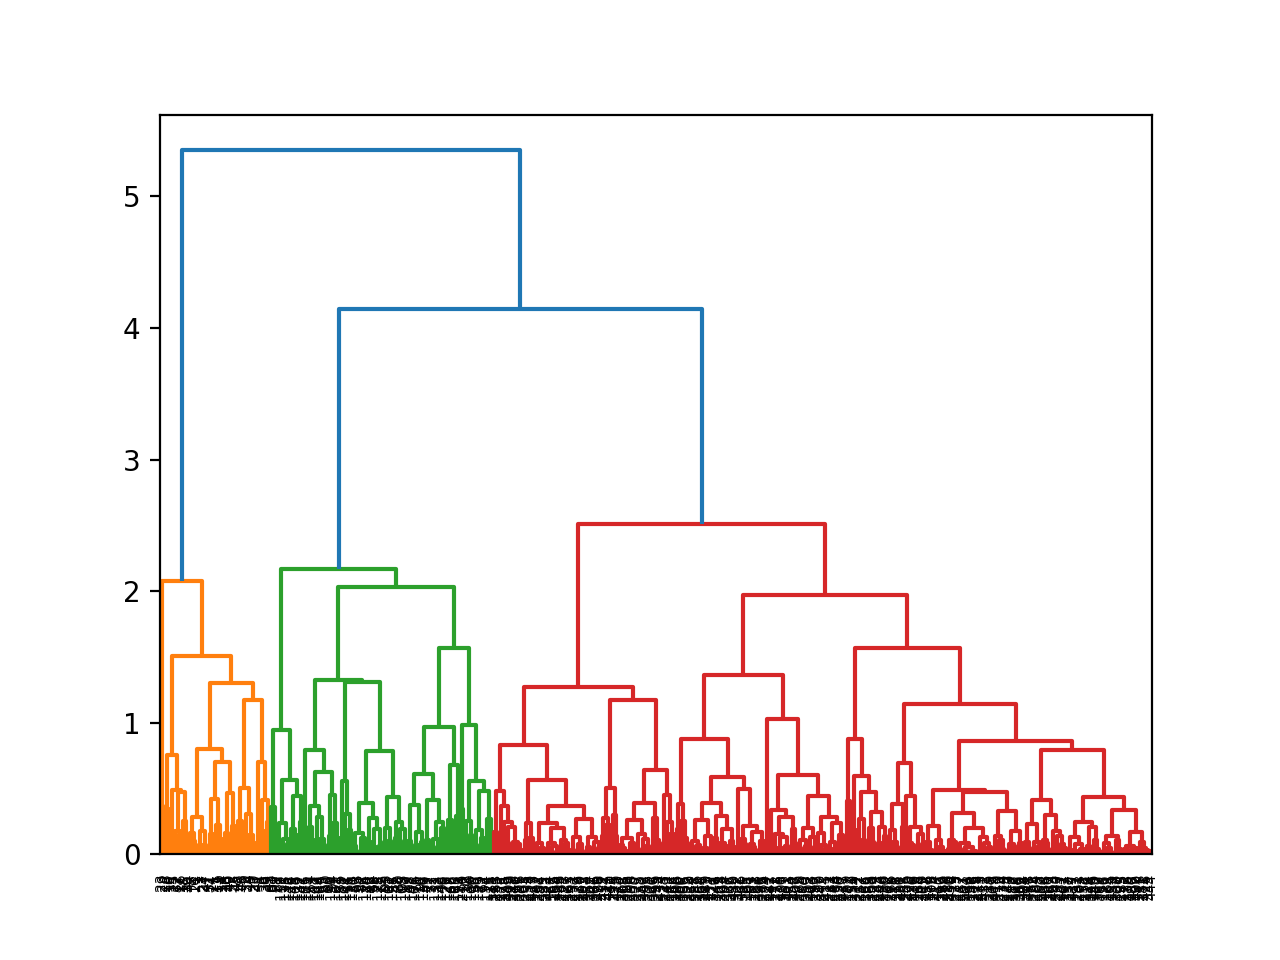

In [ ]:
# load in data
df = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/KMEM5.csv")

print(ggplot(df, aes(x = "x", y = "y")) + geom_point() + theme_minimal() +
      labs(title = "KMEM5 Data"))

# set up features
features = ["x", "y"]

X = df[features]

# create empty model
z = make_column_transformer((StandardScaler(), features),
                            remainder = "passthrough")

hac = AgglomerativeClustering(metric = "euclidean",
                             linkage = "complete",
                             distance_threshold= 0,
                             n_clusters = None) # come back and change the number of clusters

pipe3 = Pipeline([("z", z),("model", hac)])


# fit model and get labels
labels = pipe3.fit_predict(X[features])

# assess
plot_dendrogram(pipe3, color_threshold = 3)

In [ ]:
# create empty model
z = make_column_transformer((StandardScaler(), features),
                            remainder = "passthrough")

hac = AgglomerativeClustering(metric = "euclidean",
                             linkage = "complete",
                             n_clusters = 3) # come back and change the number of clusters

pipe3 = Pipeline([("z", z),("model", hac)])


# fit model and get labels
labels = pipe3.fit_predict(X[features])
print(silhouette_score(X[features], labels))

0.7029935801381054


# Classwork

## Linkage Criteria

Let's build a few functions that return the distance between two clusters. Each of these functions take in two dataframes, `A` and `B` that contain the datapoints for the two respective clusters (*number of features can vary*).

The functions take in two arguments:

* `A`: an N1 x P dataframe containing the data points in cluster A. (N1 is the number of data points in cluster A; P is the number of features used)
* `B`: an N2 x P dataframe containing the data points in cluster B. (N2 is the number of data points in cluster B; P is the number of features used)


The function should calculate and return the distance between the clusters (assume you're using euclidean distance for all of these) according to their respective linkage criterion (single, average, and complete). Remember a) that you need to calculate the distance between *every* point in `A` and *every* point in `B` and b) [`np.linalg.norm()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html).

### *Question*

1. To calculate the distance between two clusters `A` (N1 x P) and `B` (N2 x P), how many distances (between 2 data points) would you have to calculate?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

In [ ]:
### YOUR CODE HERE ###

def single(A,B):
    pass


def average(A,B):
    pass


def complete(A,B):
    pass


### /YOUR CODE HERE ###


In [ ]:
# check if your functions are working

df = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/HAC1.csv")

dA = df.loc[df.cluster == "A"] # cluster A
dB = df.loc[df.cluster == "B"] # cluster B
dC = df.loc[df.cluster == "C"] # cluster C

In [ ]:
# if complete() is correct, this will print true
completePASS = abs(complete(dA[["x","y"]], dB[["x","y"]]) - 4.718047025872837) <= 0.01
print("Complete:", completePASS)

# if average() is correct, this will print true
averagePASS = abs(average(dA[["x","y"]], dB[["x","y"]]) - 2.734811240314461) <= 0.01
print("Average:", averagePASS)

# if single() is correct, this will print true
singlePASS = abs(single(dA[["x","y"]], dB[["x","y"]]) - 0.7361237342164363) <= 0.01
print("Single:", singlePASS)


Using the dataset `df` below,

1. plot the clusters using ggplot, color by cluster
2. use your functions `single()`, `average()`, and `complete()` to calculate the distances between each pair of clusters.

### *Question*

3. Look at which clusters are considered "close" and "far" in different methods. Are there differences between which are furthest/closest between methods? What are they?

4. Describe why you think you see these differences.

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

In [ ]:
# plot


In [ ]:
# calculate distances (this will likely take a few min to run)

### YOUR CODE HERE ###

#---single------
s_AB = ###
s_AC = ###
s_BC = ###

print("AB:", s_AB)
print("AC:", s_AC)
print("BC:", s_BC)
print("\n")
#---average-----
a_AB = ###
a_AC = ###
a_BC = ###

print("AB:", a_AB)
print("AC:", a_AC)
print("BC:", a_BC)
print("\n")
#---complete----
c_AB = ###
c_AC = ###
c_BC = ###

print("AB:", c_AB)
print("AC:", c_AC)
print("BC:", c_BC)
print("\n")

### /YOUR CODE HERE ###


## Exploring Linkage Critera

Using the predictors listed in `predictors`, perform HAC on the [burger king dataset]("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/burger-king-items.txt) using sklearn and the following linkage critera:

* single linkage
* average linkage
* complete linkage
* ward's method

### *Question*
1. Plot and compare the different clusters/dendrograms that you get. What do you notice is similar/different?

2. Think hard: what do the dendrograms tell you about the data?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" width = 200px />

(NOTE: see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) if you need a refresher on how to set linkage criteria in sklearn, and [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) for how to set it for the dendrogram)

In [ ]:
burg = pd.read_csv("https://raw.githubusercontent.com/ywen2021/CPSC392/main/Data/burger-king-items.txt",
                  sep = "\t")

predictors = ["Calories", "Protein(g)", "Fat(g)", "Sodium(mg)", "Carbs(g)", "Sugar(g)"]

X = burg[predictors]

In [ ]:
### YOUR CODE HERE ###

### \YOUR CODE HERE ###

In [ ]:
### YOUR CODE HERE ###

### \YOUR CODE HERE ###

In [ ]:
### YOUR CODE HERE ###

### \YOUR CODE HERE ###

In [ ]:
### YOUR CODE HERE ###

### \YOUR CODE HERE ###